In [1]:
# import libraries
# main library in pytorch
import torch
# library that contains datasets, functions for images, pretrained models
import torchvision
# import transforms module for image preprocessing
import torchvision.transforms as transforms

# transform images to tensor (PyTorch format) with normalized values between 0 and 1
transform = transforms.ToTensor()

# download and load the MNIST training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# create a DataLoader to load data in batches of 64, shuffling the data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [3]:
# define model
from torch import nn

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [4]:
# define loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss() 
# Adam optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  

In [6]:
num_epochs = 5 
# loop over the dataset once (1 epoch)
for epoch in range(num_epochs):
    # track total loss in the epoch
    running_loss = 0.0  
    # iterate over batches from the DataLoader
    for images, labels in trainloader:
        # forward pass: compute predictions
        preds = model(images)
        
        # compute the loss
        loss = loss_fn(preds, labels)
        
        # clear gradients from the previous step
        optimizer.zero_grad()
        
        # backpropagation: compute gradients
        loss.backward()
        
        # update model weights
        optimizer.step()
        
        # convert tensor to float and accumulate
        running_loss += loss.item()  
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}")

Epoch 1/5, Loss: 144.3741
Epoch 2/5, Loss: 102.4259
Epoch 3/5, Loss: 78.1003
Epoch 4/5, Loss: 62.8204
Epoch 5/5, Loss: 51.4392


In [7]:
# load the test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# variables to track correct predictions
correct = 0
total = 0

# disable gradient calculation during evaluation
with torch.no_grad():
    for images, labels in testloader:
        # forward pass
        outputs = model(images)  
        
        # get class with highest score
        _, predicted = torch.max(outputs, 1)  

        # total number of images
        total += labels.size(0)  

        # count correct predictions
        correct += (predicted == labels).sum().item()  

# print accuracy
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 97.59%


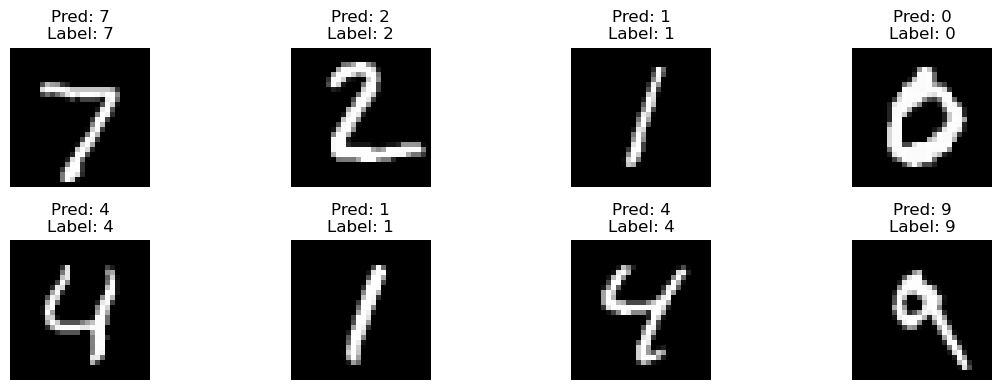

In [8]:
# visualise
import matplotlib.pyplot as plt

# get a batch of test images
images, labels = next(iter(testloader))

# get predictions (no gradients needed during inference)
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# function to show an image
def show_image(img):
    # remove channel dim (1x28x28 → 28x28)
    img = img.numpy().squeeze()  
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# plot the first 8 images with predictions and true labels
plt.figure(figsize=(12, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    show_image(images[i])
    plt.title(f"Pred: {predicted[i].item()}\nLabel: {labels[i].item()}")
plt.tight_layout()
plt.show()


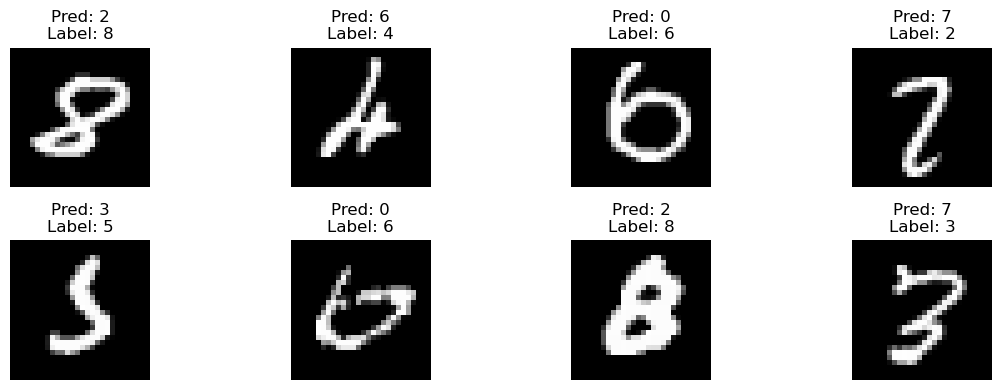

In [9]:
import matplotlib.pyplot as plt

# disable gradient calculation for efficiency during inference
with torch.no_grad():
    all_images = []
    all_labels = []
    all_preds = []

    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # find indices where predictions do not match labels (wrong predictions)
        wrong_idx = (predicted != labels).nonzero(as_tuple=True)[0]

        # store wrong images, labels and predictions
        all_images.append(images[wrong_idx])
        all_labels.append(labels[wrong_idx])
        all_preds.append(predicted[wrong_idx])

    # concatenate all wrong predictions from all batches
    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)

# function to show a single image
def show_image(img):
    img = img.numpy().squeeze()  
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.figure(figsize=(12, 4))
num_to_show = min(8, len(all_images))  

for i in range(num_to_show):
    plt.subplot(2, 4, i + 1)
    show_image(all_images[i])
    plt.title(f"Pred: {all_preds[i].item()}\nLabel: {all_labels[i].item()}")

plt.tight_layout()
plt.show()


In [10]:
# save the model
torch.save(model.state_dict(), 'mnist_model.pth')